In [10]:
import numpy as np
from skimage import data
from skimage . color import rgb2gray
import matplotlib . pyplot as plt
from mpl_toolkits . mplot3d import Axes3D
import cv2 as cv # librairie OpenCV
from tqdm import tqdm
from PIL import Image
from numba import njit

In [13]:
@njit
def block_matching(Iref, Isearch, N, maxdisp):
    disp = np.zeros_like(Iref)
    margin = N//2
    for i in np.arange(margin,Iref.shape[0] - margin):
        for j in np.arange(margin, Iref.shape[1] - margin):
            ref_block = Iref[i-margin:i+margin+1,j-margin:j+margin+1]
            min_sad=np.inf
            min_pos=0
            for x_dec in np.arange(0, maxdisp):
                new_x = j-x_dec
                if new_x >= margin:
                    search_block = Isearch[i-margin:i+margin+1, new_x-margin:new_x+margin+1]
                    sad=(np.abs(ref_block - search_block)).sum()
                    if sad < min_sad:
                        min_sad=sad
                        min_pos=x_dec
            disp[i,j]=min_pos
    return disp

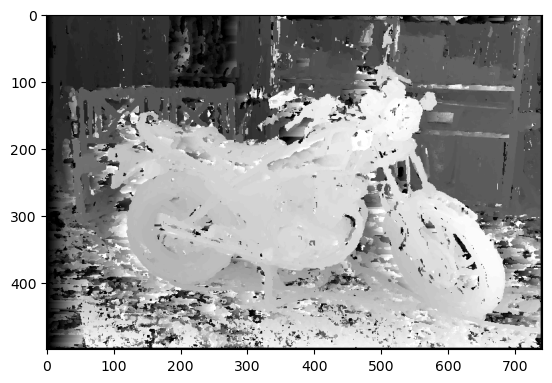

In [14]:
Ig, Id, gt = data.stereo_motorcycle()
maxdisp = 60
sto = block_matching(rgb2gray(Ig), rgb2gray(Id), 5, maxdisp)
plt.imshow(sto, cmap="gray")

In [29]:
def block_matching_2(Iref, Isearch, N, maxdisp):
    disp = np.zeros_like(Iref)
    margin = N//2
    for i in tqdm(np.arange(margin,Iref.shape[0] - margin)):
        for j in np.arange(margin, Iref.shape[1] - margin):
            ref_block = Iref[i-margin:i+margin+1,j-margin:j+margin+1]
            print(ref_block)
            # Compute bounds
            x_dec_values = np.arange(0, maxdisp)
            new_x_values = j - x_dec_values
            valid_indices = np.where(new_x_values >= margin)[0]

            # Créer des indexeurs 2D pour l'indexation de right_image
            rows = np.ix_(np.arange(i - margin, i + margin + 1), new_x_values[valid_indices] - margin)#, np.arange(right_image.shape[2]))

            search_blocks = Isearch[rows]
            print(search_blocks)
            sads = np.sum(np.abs(ref_block - search_blocks))
            
            min_pos = np.argmin(sads)
            min_x_dec = x_dec_values[valid_indices[min_pos]]

            
            disp[i,j]=min_x_dec
    return disp

In [30]:
Ig, Id, gt = data.stereo_motorcycle()
maxdisp = 60
sto = block_matching_2(rgb2gray(Ig), rgb2gray(Id), 5, maxdisp)
plt.imshow(sto, cmap="gray")

  0%|                                                   | 0/496 [00:00<?, ?it/s]

[[0.34245255 0.36035608 0.3569702  0.37237373 0.38527725]
 [0.3374     0.35113686 0.34634431 0.36115961 0.3732298 ]
 [0.32902118 0.33879882 0.34016784 0.35303373 0.37180824]
 [0.33208667 0.33794275 0.32980196 0.34464    0.3639651 ]
 [0.34104588 0.34158157 0.33090314 0.33931176 0.36368235]]
[[0.22644941]
 [0.24911569]
 [0.24718118]
 [0.23069137]
 [0.23066157]]
[[0.36035608 0.3569702  0.37237373 0.38527725 0.35644235]
 [0.35113686 0.34634431 0.36115961 0.3732298  0.35252078]
 [0.33879882 0.34016784 0.35303373 0.37180824 0.36174784]
 [0.33794275 0.32980196 0.34464    0.3639651  0.36258118]
 [0.34158157 0.33090314 0.33931176 0.36368235 0.3639651 ]]
[[0.16508039 0.22644941]
 [0.20481686 0.24911569]
 [0.20121569 0.24718118]
 [0.16064588 0.23069137]
 [0.16985804 0.23066157]]


ValueError: operands could not be broadcast together with shapes (5,5) (5,2) 

In [25]:
def mode_filter ( disp , block_size ):
    # disp : carte des disparités
    # block_size : taille du bloc de filtrage
    # retourne la carte des disparités filtrée
    # initialisation de la carte des disparités filtrée
    disp_filtered = np.zeros(disp.shape, dtype=np.uint8)
    # calcul de la moitié de la taille du bloc de filtrage
    half_block_size = block_size //2
    # parcours de la carte des disparités
    for y in range ( half_block_size , disp . shape [0] - half_block_size ):
        for x in range ( half_block_size , disp . shape [1] - half_block_size ):
            # initialisation du vecteur des disparités
            disp_vector = np . zeros ( block_size **2)
            # parcours du bloc de filtrage
            for i in range ( block_size ):
                for j in range ( block_size ):
                    disp_vector [ i * block_size + j ] = disp [ y + i - half_block_size , x + j - half_block_size ]
            # calcul de la valeur de la disparité par le filtre de mode
            disp_filtered [ y , x ] = np . bincount ( disp_vector ) . argmax ()
    return disp_filtered

In [5]:
from scipy.ndimage import mode

def filter_disparity_map(disparity_map):
    filtered_map = np.zeros_like(disparity_map)
    height, width = disparity_map.shape

    for i in range(height):
        for j in range(width):
            if i < 2 or i >= height - 2 or j < 2 or j >= width - 2:
                # Ignore border pixels
                filtered_map[i, j] = disparity_map[i, j]
            else:
                # Extract the local 5x5 window
                window = disparity_map[i-2:i+3, j-2:j+3]
                # Compute the mode of the window
                window_mode = mode(window, axis=None)[0]
                # Assign the mode to the center pixel
                filtered_map[i, j] = window_mode

    return filtered_map

ImportError: cannot import name 'mode' from 'scipy.ndimage' (/home/romain/anaconda3/lib/python3.9/site-packages/scipy/ndimage/__init__.py)

In [ ]:
# test la fonction
Ig, Id, gt = data.stereo_motorcycle ()
Iggray = (rgb2gray(Ig)*255).astype('uint8')
Idgray = (rgb2gray(Id)*255).astype('uint8')
block_size = 5
max_disp = 60
disp = mode_filter(block_matching(Iggray, Idgray, block_size, max_disp), block_size)
plt. figure ()
plt. imshow ( disp , cmap = "gray" )
plt. title ( "Carte des disparités StereoBM" )
plt.show()

 97%|███████████████████████████████████████▉ | 483/496 [01:27<00:02,  5.34it/s]